# Closed-loop replanning with JaxPlan.

This follow-up example provides another way to do closed-loop control in JaxPlan. Starting with the initial state of the system, optimize the action-fluents over a short lookahead horizon (e.g. 5 decision steps), then take the best immediate action from the plan and let the system evolve. Then repeat the process again, taking the best action from the new plan, and so on. This technique is called replanning in the planning literature, which is quite similar in flow to model-predictive control (MPC) where we obtain the dynamics model from the RDDL description.

Start by installing the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet pyRDDLGym rddlrepository pyRDDLGym-jax

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from IPython.display import Image
import os

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxBackpropPlanner, JaxOnlineController, load_config_from_string

We will again optimize the stochastic Wildfire problem from IPPC 2014, noting again the use of the ``vectorized`` option:

In [3]:
env = pyRDDLGym.make('Wildfire_MDP_ippc2014', '1', vectorized=True)

The config file is similar to the open-loop examples, except we also specify the ``rollout_horizon`` parameter to indicate how far ahead we search during optimization:

In [4]:
config = """
[Model]
comparison_kwargs={'weight': 100}
rounding_kwargs={'weight': 100}
control_kwargs={'weight': 100}
[Optimizer]
method='JaxStraightLinePlan'
optimizer_kwargs={'learning_rate': 0.1}
pgpe=None
rollout_horizon=5
[Training]
policy_hyperparams={'cut-out': 5.0, 'put-out': 5.0}
"""
planner_args, _, train_args = load_config_from_string(config)

We now initialize and run our controller. We will **set ``train_seconds`` to 1 to indicate that we want to optimize for 1 second per decision time step**:

In [5]:
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOnlineController(planner, print_summary=False, train_seconds=1, **train_args)

[INFO] JAX gradient compiler will cast p-vars {'TARGET', 'burning', "burning'", 'NEIGHBOR', 'out-of-fuel', 'cut-out', 'put-out', "out-of-fuel'"} to float.
[INFO] JAX gradient compiler will cast CPFs {"out-of-fuel'", "burning'"} to float.
[INFO] Bounds of action-fluent <put-out> set to (None, None).
[INFO] Bounds of action-fluent <cut-out> set to (None, None).
[INFO] SLP will use projected gradient to satisfy max_nondef_actions since total boolean actions 18 > max_nondef_actions 1.


Notice that no optimization is done before calling the ``evaluate`` function, because the replanning method will only optimize when it actually begins interacting with the environment, e.g. it observes the current state, finds the best action, executes it in the environment, then waits for the state to transition and begins again. 

Let's assign a visualizer so we can keep track of the behavior of the planner in real time. Then we just call ``evaluate()`` to actually do the planning:

[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


      0 it /     -370.84467 train /      -71.56250 test /      -71.56250 best / 5 status /      0 pgpe: 100%|█| 00:02 ,


[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.

[WARN] JIT compilation dominated the execution time: executing the optimizer again on the traced model [attempt 1].
[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


      1 it /      -90.22284 train /      -57.65625 test /      -57.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[WARN] JIT compilation dominated the execution time: executing the optimizer again on the traced model [attempt 2].
[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


     58 it /      -50.06115 train /      -58.62500 test /      -38.45312 best / 0 status /      0 pgpe:  10%| | 00:00 ,

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    693 it /      -42.21858 train /      -47.10938 test /      -30.71875 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    694 it /       -3.55250 train /       -3.46875 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:00 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    708 it /       -1.31989 train /       -6.14062 test /       -2.26562 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    689 it /       -3.94280 train /       -3.18750 test /       -1.40625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    661 it /       -3.05591 train /       -6.85938 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    693 it /       -3.11617 train /       -6.76562 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    707 it /       -3.54255 train /       -4.78125 test /       -2.13542 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    694 it /       -7.74359 train /       -7.70312 test /       -1.79688 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


    138 it /       -2.85928 train /       -4.31250 test /       -0.31250 best / 0 status /      0 pgpe:  21%|▏| 00:00 ,

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    702 it /       -1.31989 train /       -6.14062 test /       -0.31250 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    694 it /       -1.83605 train /       -8.42188 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    716 it /       -9.45106 train /       -6.35938 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    713 it /       -3.49654 train /       -6.14062 test /       -2.50000 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    715 it /       -1.88067 train /       -5.60938 test /       -2.34375 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    722 it /       -4.11089 train /       -7.48438 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    681 it /       -3.55250 train /       -3.46875 test /       -1.56250 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    655 it /       -3.59402 train /       -6.71875 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    708 it /       -3.49654 train /       -6.14062 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    655 it /      -10.78616 train /       -8.60938 test /       -1.40625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    624 it /       -2.51406 train /       -5.15625 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    706 it /       -2.49086 train /       -4.90625 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    690 it /       -1.31989 train /       -6.14062 test /       -2.53906 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    697 it /       -3.24108 train /       -5.00000 test /       -1.56250 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    718 it /       -1.76656 train /       -6.26562 test /       -1.09375 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    718 it /       -4.03576 train /       -6.04688 test /       -2.34375 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    689 it /       -3.54255 train /       -4.78125 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    674 it /       -3.91785 train /       -6.85938 test /       -1.40625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    701 it /       -1.88067 train /       -5.60938 test /       -0.93750 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


     67 it /       -5.17438 train /       -4.93750 test /       -1.56250 best / 0 status /      0 pgpe:  10%| | 00:00 ,

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    704 it /       -1.81274 train /       -6.07812 test /       -1.56250 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    717 it /       -5.10304 train /       -6.23438 test /       -2.65625 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    713 it /       -2.05522 train /       -5.48438 test /       -1.97917 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    703 it /       -5.38379 train /       -7.23438 test /       -1.87500 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    725 it /       -2.36136 train /       -7.29688 test /       -1.56250 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    714 it /       -5.34815 train /       -5.98438 test /       -2.03125 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    702 it /       -4.11089 train /       -7.48438 test /       -1.25000 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    669 it /       -1.83605 train /       -8.42188 test /       -2.26562 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    663 it /      -45.03198 train /      -45.59375 test /      -30.10938 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    641 it /      -70.79005 train /      -57.42188 test /      -40.92188 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    716 it /       -2.53325 train /       -3.50000 test /       -1.20312 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


  0%|                                                                                                          | 00:00 

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    668 it /       -2.00521 train /       -4.03125 test /       -1.20312 best / 5 status /      0 pgpe: 100%|█| 00:01 ,



[INFO] p-variables ['COST_CUTOUT', 'COST_PUTOUT', 'PENALTY_TARGET_BURN', 'PENALTY_NONTARGET_BURN', 'NEIGHBOR', 'TARGET', "burning'", "out-of-fuel'", 'put-out', 'cut-out'] is not in provided subs, using their initial values.


     66 it /       -5.68467 train /       -4.92188 test /       -1.37500 best / 0 status /      0 pgpe:  10%| | 00:00 ,

[FAIL] Compiler encountered the following error(s) in the training model:
    Casting occurred that could result in loss of precision.


    684 it /       -1.20655 train /       -2.50000 test /       -1.20312 best / 5 status /      0 pgpe: 100%|█| 00:01 ,


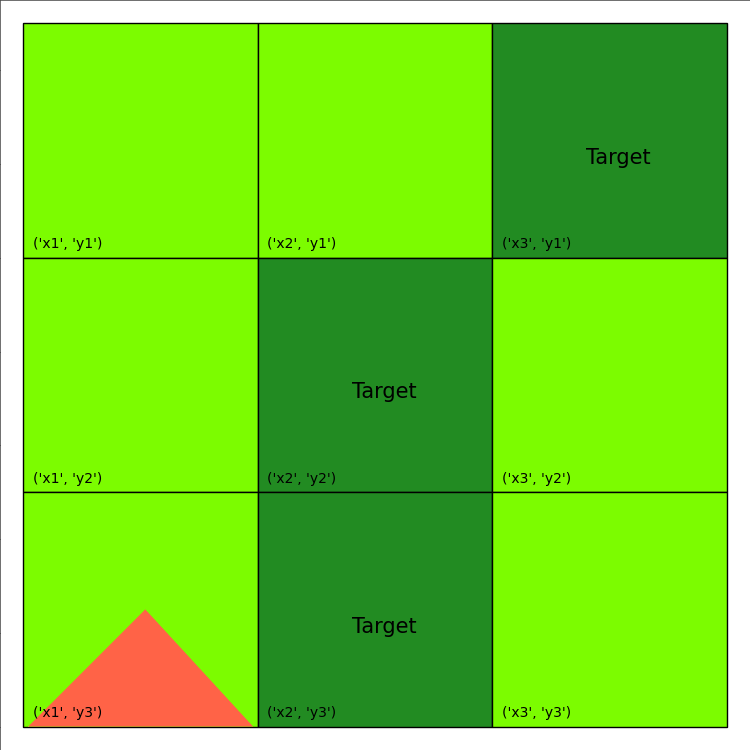

In [6]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "wildfire", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)

agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/wildfire_0.gif') 